## Install required libraries

In [1]:
!pip install obonet networkx
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install polars --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg
!pip install biopython

Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.7 MB/s eta 0:00:0000:0100:01


## Import required modules

In [2]:
import numpy as np
import pandas as pd
import os
import duckdb as dd
import polars as pl
import h5py
import networkx as nx
import obonet as ob

import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from typing import List

## Separating out the GO terms based on Ontology roots

In [3]:
def separate_go_terms_by_namespace(graph):
    """
    Separates GO terms from a networkx graph into BP, CC, and MF categories.

    Args:
        graph: A networkx MultiDiGraph loaded with obonet.

    Returns:
        A dictionary containing lists of GO term IDs for each namespace.
    """
    bp_terms = []
    cc_terms = []
    mf_terms = []

    # Iterate through every node in the graph, accessing its ID (node_id) and attributes (data)
    for node_id, data in graph.nodes(data=True):
        # The namespace is stored in the 'namespace' key of the node's data dictionary
        namespace = data.get('namespace')

        if namespace == 'biological_process':
            bp_terms.append(node_id)
        elif namespace == 'cellular_component':
            cc_terms.append(node_id)
        elif namespace == 'molecular_function':
            mf_terms.append(node_id)

    return {
        'BP': bp_terms,
        'CC': cc_terms,
        'MF': mf_terms
    }

## Load the Gene Ontology (GO) basic OBO file from the OBO Library

In [4]:
go_file_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo'
print(f"Loading Gene Ontology from {go_file_path}...")
go_graph = ob.read_obo(go_file_path)
print(f"Total terms loaded: {len(go_graph)}")

Loading Gene Ontology from /kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo...
Total terms loaded: 40122


## Separate the terms

In [5]:
separated_terms = separate_go_terms_by_namespace(go_graph)

print("\nGO Term Counts by Namespace:")
print(f"Biological Process (BP): {len(separated_terms['BP'])} terms")
print(f"Cellular Component (CC): {len(separated_terms['CC'])} terms")
print(f"Molecular Function (MF): {len(separated_terms['MF'])} terms")

print("\nFirst 5 Cellular Component (CC) terms:")
for term_id in separated_terms['CC'][:5]:
    # You can get the human-readable name using the graph data dictionary
    name = go_graph.nodes[term_id].get('name')
    print(f"- {term_id}: {name}")


GO Term Counts by Namespace:
Biological Process (BP): 25950 terms
Cellular Component (CC): 4041 terms
Molecular Function (MF): 10131 terms

First 5 Cellular Component (CC) terms:
- GO:0000015: phosphopyruvate hydratase complex
- GO:0000109: nucleotide-excision repair complex
- GO:0000110: nucleotide-excision repair factor 1 complex
- GO:0000111: nucleotide-excision repair factor 2 complex
- GO:0000112: nucleotide-excision repair factor 3 complex


## Roots of the three ontologies

In [ ]:
go_graph_edges = list(go_graph.edges)

#print(go_graph_edges[0])
print(go_graph.nodes["GO:0008150"])
print("*************")
print(go_graph.nodes["GO:0005575"])
print("*************")
print(go_graph.nodes["GO:0003674"])

In [6]:
depths_from_bp_root = nx.shortest_path_length(go_graph, target="GO:0008150")
depths_from_cc_root = nx.shortest_path_length(go_graph, target="GO:0005575")
depths_from_mf_root = nx.shortest_path_length(go_graph, target="GO:0003674")

print("Max depth of BP ontology -> ",max(depths_from_bp_root.values()))
print("Max depth of CC ontology -> ",max(depths_from_cc_root.values()))
print("Max depth of MF ontology -> ",max(depths_from_mf_root.values()))

Max depth of BP ontology ->  11
Max depth of CC ontology ->  9
Max depth of MF ontology ->  10


In [7]:
cc_terms_at_depths = {}

for i in set(depths_from_cc_root.values()):
    cc_terms_at_depths[i] = [key for key, value in depths_from_cc_root.items() if value == i]

bp_terms_at_depths = {}

for i in set(depths_from_bp_root.values()):
    bp_terms_at_depths[i] = [key for key, value in depths_from_bp_root.items() if value == i]

mf_terms_at_depths = {}

for i in set(depths_from_mf_root.values()):
    mf_terms_at_depths[i] = [key for key, value in depths_from_mf_root.items() if value == i]

### Look at the number of terms at these depths

In [10]:
for k,v in cc_terms_at_depths.items():
    print("{0} terms at depth {1}".format(len(cc_terms_at_depths[k]),k))

1 terms at depth 0
3 terms at depth 1
737 terms at depth 2
1162 terms at depth 3
1187 terms at depth 4
608 terms at depth 5
244 terms at depth 6
74 terms at depth 7
24 terms at depth 8
1 terms at depth 9


### Concatenate the CC terms at depths 0,1,7,8 and 9 since they are very less individually

In [11]:
cc_depths_to_concatenate = [0,1,7,8,9]
concatenated_cc_terms = []

for d in cc_depths_to_concatenate:
    concatenated_cc_terms = concatenated_cc_terms + cc_terms_at_depths[d]

print(len(concatenated_cc_terms))

103


In [43]:
for k,v in mf_terms_at_depths.items():
    print("{0} terms at depth {1}".format(len(mf_terms_at_depths[k]),k))

1 terms at depth 0
32 terms at depth 1
183 terms at depth 2
889 terms at depth 3
1905 terms at depth 4
4364 terms at depth 5
1868 terms at depth 6
675 terms at depth 7
163 terms at depth 8
50 terms at depth 9
1 terms at depth 10


### Concatenate the MF terms at depths 0,1,8,9 and 10 since they are very less individually

In [44]:
mf_depths_to_concatenate = [0,1,8,9,10]
concatenated_mf_terms = []

for d in mf_depths_to_concatenate:
    concatenated_mf_terms = concatenated_mf_terms + mf_terms_at_depths[d]

print(len(concatenated_mf_terms))

247


In [8]:
for k,v in bp_terms_at_depths.items():
    print("{0} terms at depth {1}".format(len(bp_terms_at_depths[k]),k))

1 terms at depth 0
21 terms at depth 1
409 terms at depth 2
3163 terms at depth 3
6726 terms at depth 4
7591 terms at depth 5
4539 terms at depth 6
2335 terms at depth 7
880 terms at depth 8
195 terms at depth 9
70 terms at depth 10
20 terms at depth 11


### Concatenate the terms at depths 0,1,9,10 and 11 since they are very less individually

In [9]:
bp_depths_to_concatenate = [0,1,9,10,11]
concatenated_bp_terms = []

for d in bp_depths_to_concatenate:
    concatenated_bp_terms = concatenated_bp_terms + bp_terms_at_depths[d]

print(len(concatenated_bp_terms))

307


## Introduce the ESM2 embeddings of dimension 480

In [10]:
emb_df = pl.read_parquet('/kaggle/input/cafa6-protein-go-terms-feat-labels/train_protein_features_esm2_480.parquet')
emb_df.shape

(82404, 2)

In [13]:
emb_df.head(5)

protein_accession_id,embedding_arrays
str,"array[f32, 480]"
"""Q8H2B4""","[-0.155396, -0.092102, … 0.036743]"
"""O01836""","[-0.121338, 0.071411, … 0.01651]"
"""Q13309""","[-0.148682, 0.137695, … -0.005337]"
"""Q9UPW5""","[-0.016464, -0.000262, … 0.102783]"
"""P70453""","[-0.175415, 0.082336, … -0.007427]"


## Bring in the training data; proteins and the corresponding GO terms

In [11]:
train_terms_df = pl.read_csv('/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv', separator='\t')
train_terms_df.shape

(537027, 3)

In [12]:
dd.sql("select count(distinct(EntryID)) as uniq_prots, count(distinct(term)) as uniq_terms from train_terms_df").pl()

uniq_prots,uniq_terms
i64,i64
82404,26125


In [14]:
train_terms_df.head(4)

EntryID,term,aspect
str,str,str
"""Q5W0B1""","""GO:0000785""","""C"""
"""Q5W0B1""","""GO:0004842""","""F"""
"""Q5W0B1""","""GO:0051865""","""P"""
"""Q5W0B1""","""GO:0006275""","""P"""


## Introduce the embeddings into the training data

In [12]:
train_terms_w_embeds = dd.sql("select distinct t1.protein_accession_id, t2.term, t2.aspect \
, t1.embedding_arrays as protein_embedding \
from emb_df t1 \
join train_terms_df t2 \
on t1.protein_accession_id = t2.EntryID").pl()

print(train_terms_w_embeds.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(537027, 4)


In [14]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids, \
count(distinct(term)) as uniq_go_terms from train_terms_w_embeds").pl()

uniq_protein_accession_ids,uniq_go_terms
i64,i64
82404,26125


## Create separate dataframes for each root ontology based on their depths

### CC

In [17]:
train_terms_w_embeds_cc_concat = train_terms_w_embeds.filter(pl.col("term").is_in(concatenated_cc_terms))
print("train_terms_w_embeds_cc_concat shape -> ",train_terms_w_embeds_cc_concat.shape)

train_terms_w_embeds_cc_2 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[2]))
print("train_terms_w_embeds_cc_2 shape -> ",train_terms_w_embeds_cc_2.shape)

train_terms_w_embeds_cc_3 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[3]))
print("train_terms_w_embeds_cc_3 shape -> ",train_terms_w_embeds_cc_3.shape)

train_terms_w_embeds_cc_4 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[4]))
print("train_terms_w_embeds_cc_4 shape -> ",train_terms_w_embeds_cc_4.shape)

train_terms_w_embeds_cc_5 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[5]))
print("train_terms_w_embeds_cc_5 shape -> ",train_terms_w_embeds_cc_5.shape)

train_terms_w_embeds_cc_6 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[6]))
print("train_terms_w_embeds_cc_6 shape -> ",train_terms_w_embeds_cc_6.shape)

train_terms_w_embeds_cc_concat shape ->  (2125, 4)
train_terms_w_embeds_cc_2 shape ->  (50224, 4)
train_terms_w_embeds_cc_3 shape ->  (47468, 4)
train_terms_w_embeds_cc_4 shape ->  (27910, 4)
train_terms_w_embeds_cc_5 shape ->  (26130, 4)
train_terms_w_embeds_cc_6 shape ->  (3913, 4)


## MF

In [48]:
train_terms_w_embeds_mf_concat = train_terms_w_embeds.filter(pl.col("term").is_in(concatenated_mf_terms)) # 0,1,8,9,10
print("train_terms_w_embeds_mf_concat shape -> ",train_terms_w_embeds_mf_concat.shape)

train_terms_w_embeds_mf_2 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[2]))
print("train_terms_w_embeds_mf_2 shape -> ",train_terms_w_embeds_mf_2.shape)

train_terms_w_embeds_mf_3 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[3]))
print("train_terms_w_embeds_mf_3 shape -> ",train_terms_w_embeds_mf_3.shape)

train_terms_w_embeds_mf_4 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[4]))
print("train_terms_w_embeds_mf_4 shape -> ",train_terms_w_embeds_mf_4.shape)

train_terms_w_embeds_mf_5 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[5]))
print("train_terms_w_embeds_mf_5 shape -> ",train_terms_w_embeds_mf_5.shape)

train_terms_w_embeds_mf_6 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[6]))
print("train_terms_w_embeds_mf_6 shape -> ",train_terms_w_embeds_mf_6.shape)

train_terms_w_embeds_mf_7 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[7]))
print("train_terms_w_embeds_mf_7 shape -> ",train_terms_w_embeds_mf_7.shape)

train_terms_w_embeds_mf_concat shape ->  (2084, 4)
train_terms_w_embeds_mf_2 shape ->  (41554, 4)
train_terms_w_embeds_mf_3 shape ->  (21514, 4)
train_terms_w_embeds_mf_4 shape ->  (25247, 4)
train_terms_w_embeds_mf_5 shape ->  (21761, 4)
train_terms_w_embeds_mf_6 shape ->  (11221, 4)
train_terms_w_embeds_mf_7 shape ->  (5071, 4)


## BP

In [13]:
train_terms_w_embeds_bp_concat = train_terms_w_embeds.filter(pl.col("term").is_in(concatenated_bp_terms)) # 0,1,9,10,11
print("train_terms_w_embeds_bp_concat shape -> ",train_terms_w_embeds_bp_concat.shape)

train_terms_w_embeds_bp_2 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[2]))
print("train_terms_w_embeds_bp_2 shape -> ",train_terms_w_embeds_bp_2.shape)

train_terms_w_embeds_bp_3 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[3]))
print("train_terms_w_embeds_bp_3 shape -> ",train_terms_w_embeds_bp_3.shape)

train_terms_w_embeds_bp_4 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[4]))
print("train_terms_w_embeds_bp_4 shape -> ",train_terms_w_embeds_bp_4.shape)

train_terms_w_embeds_bp_5 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[5]))
print("train_terms_w_embeds_bp_5 shape -> ",train_terms_w_embeds_bp_5.shape)

train_terms_w_embeds_bp_6 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[6]))
print("train_terms_w_embeds_bp_6 shape -> ",train_terms_w_embeds_bp_6.shape)

train_terms_w_embeds_bp_7 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[7]))
print("train_terms_w_embeds_bp_7 shape -> ",train_terms_w_embeds_bp_7.shape)

train_terms_w_embeds_bp_8 = train_terms_w_embeds.filter(pl.col("term").is_in(mf_terms_at_depths[8]))
print("train_terms_w_embeds_bp_8 shape -> ",train_terms_w_embeds_bp_8.shape)

train_terms_w_embeds_bp_concat shape ->  (3455, 4)
train_terms_w_embeds_bp_2 shape ->  (41554, 4)
train_terms_w_embeds_bp_3 shape ->  (21514, 4)
train_terms_w_embeds_bp_4 shape ->  (25247, 4)
train_terms_w_embeds_bp_5 shape ->  (21761, 4)
train_terms_w_embeds_bp_6 shape ->  (11221, 4)
train_terms_w_embeds_bp_7 shape ->  (5071, 4)
train_terms_w_embeds_bp_8 shape ->  (874, 4)


In [14]:
pl.Config(fmt_str_lengths=1000)
pl.Config.set_tbl_rows(1000)

polars.config.Config

In [32]:
print(dd.sql("select term, \
count(distinct(protein_accession_id)) as uniq_records from train_terms_w_embeds_cc_6 group by term \
order by count(distinct(protein_accession_id)) desc").pl())

shape: (133, 2)
┌────────────┬──────────────┐
│ term       ┆ uniq_records │
│ ---        ┆ ---          │
│ str        ┆ i64          │
╞════════════╪══════════════╡
│ GO:0005765 ┆ 384          │
│ GO:0015629 ┆ 336          │
│ GO:0000329 ┆ 302          │
│ GO:0015630 ┆ 288          │
│ GO:0072686 ┆ 265          │
│ GO:0005874 ┆ 229          │
│ GO:0005884 ┆ 133          │
│ GO:0005923 ┆ 122          │
│ GO:0062040 ┆ 96           │
│ GO:0030670 ┆ 93           │
│ GO:0005876 ┆ 92           │
│ GO:0014704 ┆ 84           │
│ GO:0000793 ┆ 82           │
│ GO:0000228 ┆ 81           │
│ GO:0005700 ┆ 79           │
│ GO:0035267 ┆ 75           │
│ GO:0030669 ┆ 73           │
│ GO:0005882 ┆ 68           │
│ GO:0046540 ┆ 66           │
│ GO:0097729 ┆ 66           │
│ GO:0045111 ┆ 52           │
│ GO:0072687 ┆ 44           │
│ GO:0032009 ┆ 40           │
│ GO:0032281 ┆ 36           │
│ GO:0034704 ┆ 35           │
│ GO:0017146 ┆ 24           │
│ GO:0032010 ┆ 23           │
│ GO:0032585 ┆ 23       

In [47]:
train_terms_w_embeds_bp = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['BP']))
print("train_terms_w_embeds_bp shape -> ",train_terms_w_embeds_bp.shape)

train_terms_w_embeds_cc = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['CC']))
print("train_terms_w_embeds_cc shape -> ",train_terms_w_embeds_cc.shape)

train_terms_w_embeds_mf = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['MF']))
print("train_terms_w_embeds_mf shape -> ",train_terms_w_embeds_mf.shape)

train_terms_w_embeds_bp shape ->  (250805, 4)
train_terms_w_embeds_cc shape ->  (157770, 4)
train_terms_w_embeds_mf shape ->  (128452, 4)


## Get the most frequently occuring GO terms

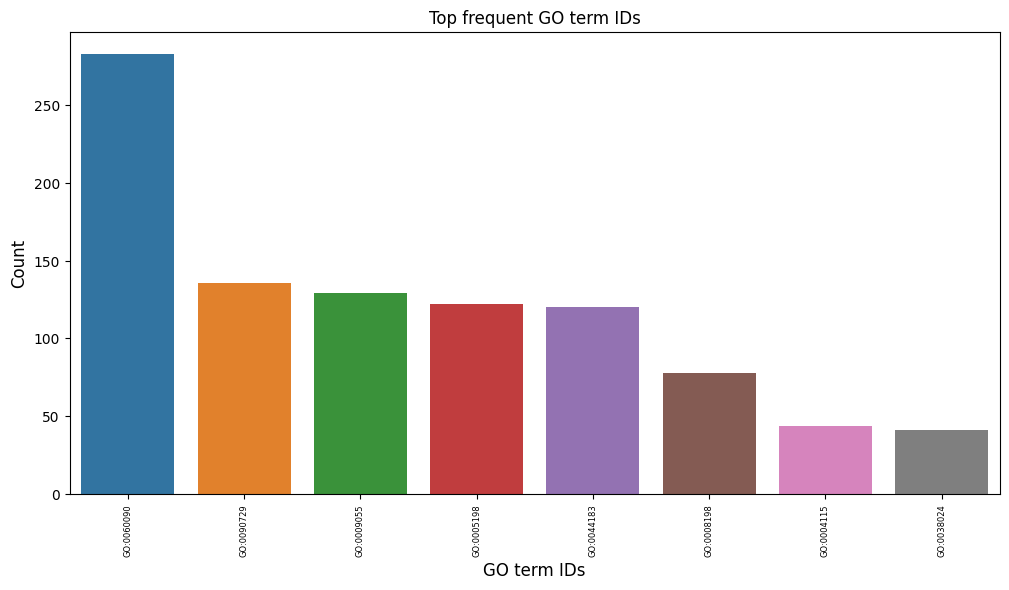

In [49]:
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds_mf_concat group by term \
having count(1) >= 40 order by count(1) desc ").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [15]:
num_of_labels = 1500

def train_labels_per_ontology_pl(input_df: pl.DataFrame, input_num_of_labels: int) -> pl.DataFrame:
    """
    Filters a Polars DataFrame to include only the top N most frequent terms.
    
    Args:
        input_df: The input Polars DataFrame with a 'term' column.
        input_num_of_labels: The number of top terms to keep.
        
    Returns:
        A new Polars DataFrame containing only the top N frequent labels.
    """

    # 1. Calculate the top N frequent terms using Polars methods
    # top_labels_df = input_df.group_by("term").count().sort("count", descending=True).limit(input_num_of_labels)
    top_labels_df = input_df.group_by("term").agg(pl.col("protein_accession_id").n_unique().alias("unique_protein_count"))\
    .filter(pl.col("unique_protein_count") >= input_num_of_labels)
    
    # 2. Extract these top terms into a Python list
    labels_list: List[str] = top_labels_df["term"].to_list()
    
    # 3. Filter the original DataFrame to keep only those terms
    train_labels = input_df.filter(pl.col("term").is_in(labels_list))
    
    print(f"Shape of filtered training data: {train_labels.shape}")
    print("Head of filtered training data:")
    print(train_labels.head())

    return train_labels


In [23]:
result = (
    train_terms_w_embeds_cc_concat.group_by("term")
    .agg(pl.col("protein_accession_id").n_unique().alias("unique_protein_count"))
    .filter(pl.col("unique_protein_count") >= 50)
)

result["term"].to_list()

['GO:0001673', 'GO:0000307', 'GO:0000794', 'GO:0032991', 'GO:0036126']

## CC

In [35]:
train_terms_cc_concat = train_labels_per_ontology_pl(train_terms_w_embeds_cc_concat, 40)
train_terms_cc_2 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_2, 40)
train_terms_cc_3 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_3, 40)
train_terms_cc_4 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_4, 40)
train_terms_cc_5 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_5, 40)
train_terms_cc_6 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_6, 40)

Shape of filtered training data: (1762, 4)
Head of filtered training data:
shape: (5, 4)
┌──────────────────────┬────────────┬────────┬────────────────────────────────────┐
│ protein_accession_id ┆ term       ┆ aspect ┆ protein_embedding                  │
│ ---                  ┆ ---        ┆ ---    ┆ ---                                │
│ str                  ┆ str        ┆ str    ┆ array[f32, 480]                    │
╞══════════════════════╪════════════╪════════╪════════════════════════════════════╡
│ P49336               ┆ GO:0000307 ┆ C      ┆ [-0.130981, 0.023651, … -0.017792] │
│ Q63356               ┆ GO:0032991 ┆ C      ┆ [-0.055969, -0.034729, … 0.081299] │
│ O14727               ┆ GO:0032991 ┆ C      ┆ [-0.068481, -0.082092, … 0.072632] │
│ Q9DAJ2               ┆ GO:0036126 ┆ C      ┆ [0.022308, -0.032776, … -0.020523] │
│ P63041               ┆ GO:0032991 ┆ C      ┆ [-0.197021, 0.020767, … -0.037628] │
└──────────────────────┴────────────┴────────┴─────────────────────────

## MF

In [54]:
train_terms_mf_concat = train_labels_per_ontology_pl(train_terms_w_embeds_mf_concat, 40)
train_terms_mf_2 = train_labels_per_ontology_pl(train_terms_w_embeds_mf_2, 40)
train_terms_mf_3 = train_labels_per_ontology_pl(train_terms_w_embeds_mf_3, 40)
train_terms_mf_4 = train_labels_per_ontology_pl(train_terms_w_embeds_mf_4, 40)
train_terms_mf_5 = train_labels_per_ontology_pl(train_terms_w_embeds_mf_5, 40)
train_terms_mf_6 = train_labels_per_ontology_pl(train_terms_w_embeds_mf_6, 40)
train_terms_mf_7 = train_labels_per_ontology_pl(train_terms_w_embeds_mf_7, 40)

Shape of filtered training data: (953, 4)
Head of filtered training data:
shape: (5, 4)
┌──────────────────────┬────────────┬────────┬─────────────────────────────────────┐
│ protein_accession_id ┆ term       ┆ aspect ┆ protein_embedding                   │
│ ---                  ┆ ---        ┆ ---    ┆ ---                                 │
│ str                  ┆ str        ┆ str    ┆ array[f32, 480]                     │
╞══════════════════════╪════════════╪════════╪═════════════════════════════════════╡
│ Q96DN5               ┆ GO:0060090 ┆ F      ┆ [-0.010498, -0.02388, … 0.039825]   │
│ P35179               ┆ GO:0005198 ┆ F      ┆ [-0.132935, -0.058258, … 0.053741]  │
│ P0ABJ3               ┆ GO:0009055 ┆ F      ┆ [-0.046387, -0.082581, … -0.212769] │
│ O60658               ┆ GO:0004115 ┆ F      ┆ [-0.016098, -0.013397, … 0.055634]  │
│ P76621               ┆ GO:0008198 ┆ F      ┆ [-0.03595, 0.051605, … -0.121216]   │
└──────────────────────┴────────────┴────────┴────────────────

## BP

In [16]:
train_terms_bp_concat = train_labels_per_ontology_pl(train_terms_w_embeds_bp_concat, 40)
train_terms_bp_2 = train_labels_per_ontology_pl(train_terms_w_embeds_bp_2, 40)
train_terms_bp_3 = train_labels_per_ontology_pl(train_terms_w_embeds_bp_3, 40)
train_terms_bp_4 = train_labels_per_ontology_pl(train_terms_w_embeds_bp_4, 40)
train_terms_bp_5 = train_labels_per_ontology_pl(train_terms_w_embeds_bp_5, 40)
train_terms_bp_6 = train_labels_per_ontology_pl(train_terms_w_embeds_bp_6, 40)
train_terms_bp_7 = train_labels_per_ontology_pl(train_terms_w_embeds_bp_7, 40)
train_terms_bp_8 = train_labels_per_ontology_pl(train_terms_w_embeds_bp_8, 40)

Shape of filtered training data: (2068, 4)
Head of filtered training data:
shape: (5, 4)
┌──────────────────────┬────────────┬────────┬───────────────────────────────────┐
│ protein_accession_id ┆ term       ┆ aspect ┆ protein_embedding                 │
│ ---                  ┆ ---        ┆ ---    ┆ ---                               │
│ str                  ┆ str        ┆ str    ┆ array[f32, 480]                   │
╞══════════════════════╪════════════╪════════╪═══════════════════════════════════╡
│ P29311               ┆ GO:0031397 ┆ P      ┆ [-0.074524, 0.040314, … 0.074402] │
│ Q6UXN9               ┆ GO:0032968 ┆ P      ┆ [-0.141968, 0.12854, … 0.076965]  │
│ P32570               ┆ GO:0060261 ┆ P      ┆ [-0.045471, 0.10022, … -0.071045] │
│ Q8WZ19               ┆ GO:0016567 ┆ P      ┆ [-0.110718, 0.008369, … 0.014069] │
│ Q8BIA4               ┆ GO:0016567 ┆ P      ┆ [-0.063538, 0.018814, … 0.063293] │
└──────────────────────┴────────────┴────────┴───────────────────────────────────

## CC

In [37]:
train_protein_labels_cc_concat = train_terms_cc_concat.select(['protein_accession_id','term'])
print(train_protein_labels_cc_concat.head(5))

train_protein_labels_cc_2 = train_terms_cc_2.select(['protein_accession_id','term'])
print(train_protein_labels_cc_2.head(5))

train_protein_labels_cc_3 = train_terms_cc_3.select(['protein_accession_id','term'])
print(train_protein_labels_cc_3.head(5))

train_protein_labels_cc_4 = train_terms_cc_4.select(['protein_accession_id','term'])
print(train_protein_labels_cc_4.head(5))

train_protein_labels_cc_5 = train_terms_cc_5.select(['protein_accession_id','term'])
print(train_protein_labels_cc_5.head(5))

train_protein_labels_cc_6 = train_terms_cc_6.select(['protein_accession_id','term'])
print(train_protein_labels_cc_6.head(5))

shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ P49336               ┆ GO:0000307 │
│ Q63356               ┆ GO:0032991 │
│ O14727               ┆ GO:0032991 │
│ Q9DAJ2               ┆ GO:0036126 │
│ P63041               ┆ GO:0032991 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ P14737               ┆ GO:0000785 │
│ P51784               ┆ GO:0005829 │
│ Q2XU92               ┆ GO:0005829 │
│ Q9UL18               ┆ GO:0005737 │
│ Q69YN4               ┆ GO:0005829 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str   

## MF

In [55]:
train_protein_labels_mf_concat = train_terms_mf_concat.select(['protein_accession_id','term'])
print(train_protein_labels_mf_concat.head(5))

train_protein_labels_mf_2 = train_terms_mf_2.select(['protein_accession_id','term'])
print(train_protein_labels_mf_2.head(5))

train_protein_labels_mf_3 = train_terms_mf_3.select(['protein_accession_id','term'])
print(train_protein_labels_mf_3.head(5))

train_protein_labels_mf_4 = train_terms_mf_4.select(['protein_accession_id','term'])
print(train_protein_labels_mf_4.head(5))

train_protein_labels_mf_5 = train_terms_mf_5.select(['protein_accession_id','term'])
print(train_protein_labels_mf_5.head(5))

train_protein_labels_mf_6 = train_terms_mf_6.select(['protein_accession_id','term'])
print(train_protein_labels_mf_6.head(5))

train_protein_labels_mf_7 = train_terms_mf_7.select(['protein_accession_id','term'])
print(train_protein_labels_mf_7.head(5))

shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ Q96DN5               ┆ GO:0060090 │
│ P35179               ┆ GO:0005198 │
│ P0ABJ3               ┆ GO:0009055 │
│ O60658               ┆ GO:0004115 │
│ P76621               ┆ GO:0008198 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ P15028               ┆ GO:0005515 │
│ Q92377               ┆ GO:0005515 │
│ P58660               ┆ GO:0005515 │
│ Q08050               ┆ GO:0003700 │
│ P9WPF9               ┆ GO:0005515 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str   

## BP

In [17]:
train_protein_labels_bp_concat = train_terms_bp_concat.select(['protein_accession_id','term'])
print(train_protein_labels_bp_concat.head(5))

train_protein_labels_bp_2 = train_terms_bp_2.select(['protein_accession_id','term'])
print(train_protein_labels_bp_2.head(5))

train_protein_labels_bp_3 = train_terms_bp_3.select(['protein_accession_id','term'])
print(train_protein_labels_bp_3.head(5))

train_protein_labels_bp_4 = train_terms_bp_4.select(['protein_accession_id','term'])
print(train_protein_labels_bp_4.head(5))

train_protein_labels_bp_5 = train_terms_bp_5.select(['protein_accession_id','term'])
print(train_protein_labels_bp_5.head(5))

train_protein_labels_bp_6 = train_terms_bp_6.select(['protein_accession_id','term'])
print(train_protein_labels_bp_6.head(5))

train_protein_labels_bp_7 = train_terms_bp_7.select(['protein_accession_id','term'])
print(train_protein_labels_bp_7.head(5))

train_protein_labels_bp_8 = train_terms_bp_8.select(['protein_accession_id','term'])
print(train_protein_labels_bp_8.shape)
print(train_protein_labels_bp_8.head(5))

shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ P29311               ┆ GO:0031397 │
│ Q6UXN9               ┆ GO:0032968 │
│ P32570               ┆ GO:0060261 │
│ Q8WZ19               ┆ GO:0016567 │
│ Q8BIA4               ┆ GO:0016567 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ Q9M0E2               ┆ GO:0003735 │
│ P56392               ┆ GO:0004129 │
│ P25649               ┆ GO:0005515 │
│ O80397               ┆ GO:0005515 │
│ P53894               ┆ GO:0005515 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str   

In [18]:
def get_pivoted_df(input_df: pl.DataFrame) -> pl.DataFrame:
    train_protein_labels_w_term_presence = input_df.with_columns(
        pl.lit(1.0).alias("presence")
    )

    pivoted_df = train_protein_labels_w_term_presence.pivot(
        index="protein_accession_id",
        on="term",
        values="presence",  
        aggregate_function="sum"
    )
    
    pivoted_df = pivoted_df.fill_null(0)
    print(pivoted_df.head(5))
    return pivoted_df

## CC

In [39]:
pivoted_df_cc_concat = get_pivoted_df(train_protein_labels_cc_concat)
pivoted_df_cc_2 = get_pivoted_df(train_protein_labels_cc_2)
pivoted_df_cc_3 = get_pivoted_df(train_protein_labels_cc_3)
pivoted_df_cc_4 = get_pivoted_df(train_protein_labels_cc_4)
pivoted_df_cc_5 = get_pivoted_df(train_protein_labels_cc_5)
pivoted_df_cc_6 = get_pivoted_df(train_protein_labels_cc_6)

shape: (5, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ protein_ac ┆ GO:0000307 ┆ GO:0032991 ┆ GO:003612 ┆ GO:000582 ┆ GO:000079 ┆ GO:000167 ┆ GO:004509 │
│ cession_id ┆ ---        ┆ ---        ┆ 6         ┆ 8         ┆ 4         ┆ 3         ┆ 5         │
│ ---        ┆ f64        ┆ f64        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆            ┆            ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ P49336     ┆ 1.0        ┆ 1.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ Q63356     ┆ 0.0        ┆ 1.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ O14727     ┆ 0.0        ┆ 1.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ Q9DAJ2     ┆ 0.0        ┆ 0.0        ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ 

In [40]:
print(pivoted_df_cc_concat.shape)
print(pivoted_df_cc_2.shape)
print(pivoted_df_cc_3.shape)
print(pivoted_df_cc_4.shape)
print(pivoted_df_cc_5.shape)
print(pivoted_df_cc_6.shape)

(1735, 8)
(32471, 73)
(30010, 104)
(17310, 112)
(19769, 74)
(2855, 24)


## MF

In [56]:
pivoted_df_mf_concat = get_pivoted_df(train_protein_labels_mf_concat)
pivoted_df_mf_2 = get_pivoted_df(train_protein_labels_mf_2)
pivoted_df_mf_3 = get_pivoted_df(train_protein_labels_mf_3)
pivoted_df_mf_4 = get_pivoted_df(train_protein_labels_mf_4)
pivoted_df_mf_5 = get_pivoted_df(train_protein_labels_mf_5)
pivoted_df_mf_6 = get_pivoted_df(train_protein_labels_mf_6)
pivoted_df_mf_7 = get_pivoted_df(train_protein_labels_mf_7)

shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ protein_a ┆ GO:006009 ┆ GO:000519 ┆ GO:000905 ┆ … ┆ GO:000819 ┆ GO:004418 ┆ GO:003802 ┆ GO:00907 │
│ ccession_ ┆ 0         ┆ 8         ┆ 5         ┆   ┆ 8         ┆ 3         ┆ 4         ┆ 29       │
│ id        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ ---       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│ str       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Q96DN5    ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ P35179    ┆ 0.0       ┆ 1.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ P0ABJ3    ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ … ┆ 0.0       ┆ 0.0       ┆

In [57]:
print(pivoted_df_mf_concat.shape)
print(pivoted_df_mf_2.shape)
print(pivoted_df_mf_3.shape)
print(pivoted_df_mf_4.shape)
print(pivoted_df_mf_5.shape)
print(pivoted_df_mf_6.shape)
print(pivoted_df_mf_7.shape)

(934, 9)
(36309, 39)
(13445, 92)
(13127, 90)
(8063, 82)
(3957, 39)
(2195, 16)


## BP

In [19]:
pivoted_df_bp_concat = get_pivoted_df(train_protein_labels_bp_concat)
pivoted_df_bp_2 = get_pivoted_df(train_protein_labels_bp_2)
pivoted_df_bp_3 = get_pivoted_df(train_protein_labels_bp_3)
pivoted_df_bp_4 = get_pivoted_df(train_protein_labels_bp_4)
pivoted_df_bp_5 = get_pivoted_df(train_protein_labels_bp_5)
pivoted_df_bp_6 = get_pivoted_df(train_protein_labels_bp_6)
pivoted_df_bp_7 = get_pivoted_df(train_protein_labels_bp_7)
pivoted_df_bp_8 = get_pivoted_df(train_protein_labels_bp_8)

shape: (5, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ protein_a ┆ GO:003139 ┆ GO:003296 ┆ GO:006026 ┆ … ┆ GO:004001 ┆ GO:000033 ┆ GO:003150 ┆ GO:00063 │
│ ccession_ ┆ 7         ┆ 8         ┆ 1         ┆   ┆ 1         ┆ 8         ┆ 9         ┆ 46       │
│ id        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ ---       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│ str       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ P29311    ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ Q6UXN9    ┆ 0.0       ┆ 1.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ P32570    ┆ 0.0       ┆ 1.0       ┆ 1.0       ┆ … ┆ 0.0       ┆ 0.0       

In [20]:
print(pivoted_df_bp_concat.shape)
print(pivoted_df_bp_2.shape)
print(pivoted_df_bp_3.shape)
print(pivoted_df_bp_4.shape)
print(pivoted_df_bp_5.shape)
print(pivoted_df_bp_6.shape)
print(pivoted_df_bp_7.shape)
print(pivoted_df_bp_8.shape)

(1641, 20)
(36309, 39)
(13445, 92)
(13127, 90)
(8063, 82)
(3957, 39)
(2195, 16)
(121, 3)


## CC

In [41]:
train_protein_features_cc_concat = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_concat").pl()
print(train_protein_features_cc_concat.head(5))

train_protein_features_cc_2 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_2").pl()
print(train_protein_features_cc_2.head(5))

train_protein_features_cc_3 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_3").pl()
print(train_protein_features_cc_3.head(5))

train_protein_features_cc_4 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_4").pl()
print(train_protein_features_cc_4.head(5))

train_protein_features_cc_5 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_5").pl()
print(train_protein_features_cc_5.head(5))

train_protein_features_cc_6 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_6").pl()
print(train_protein_features_cc_6.head(5))

shape: (5, 2)
┌──────────────────────┬─────────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding                   │
│ ---                  ┆ ---                                 │
│ str                  ┆ array[f32, 480]                     │
╞══════════════════════╪═════════════════════════════════════╡
│ P13646               ┆ [-0.057404, -0.077576, … -0.033417] │
│ Q6S5J6               ┆ [-0.063477, -0.018494, … 0.004074]  │
│ Q9NSB2               ┆ [-0.077332, -0.113708, … 0.017227]  │
│ P35511               ┆ [-0.026901, -0.074646, … 0.082886]  │
│ P0A853               ┆ [-0.065308, 0.016464, … -0.004639]  │
└──────────────────────┴─────────────────────────────────────┘
shape: (5, 2)
┌──────────────────────┬─────────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding                   │
│ ---                  ┆ ---                                 │
│ str                  ┆ array[f32, 480]                     │
╞══════════════════════╪═══

## MF

In [58]:
train_protein_features_mf_concat = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_mf_concat").pl()
print(train_protein_features_mf_concat.head(5))

train_protein_features_mf_2 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_mf_2").pl()
print(train_protein_features_mf_2.head(5))

train_protein_features_mf_3 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_mf_3").pl()
print(train_protein_features_mf_3.head(5))

train_protein_features_mf_4 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_mf_4").pl()
print(train_protein_features_mf_4.head(5))

train_protein_features_mf_5 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_mf_5").pl()
print(train_protein_features_mf_5.head(5))

train_protein_features_mf_6 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_mf_6").pl()
print(train_protein_features_mf_6.head(5))

train_protein_features_mf_7 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_mf_7").pl()
print(train_protein_features_mf_7.head(5))

shape: (5, 2)
┌──────────────────────┬─────────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding                   │
│ ---                  ┆ ---                                 │
│ str                  ┆ array[f32, 480]                     │
╞══════════════════════╪═════════════════════════════════════╡
│ O88884               ┆ [-0.110291, -0.018509, … -0.055206] │
│ Q9FKW6               ┆ [-0.249268, -0.042725, … 0.005108]  │
│ Q03020               ┆ [-0.263184, -0.090149, … -0.051849] │
│ F8J4S0               ┆ [-0.105896, -0.148926, … 0.042145]  │
│ Q3TIR3               ┆ [-0.087341, -0.007404, … 0.026764]  │
└──────────────────────┴─────────────────────────────────────┘
shape: (5, 2)
┌──────────────────────┬────────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding                  │
│ ---                  ┆ ---                                │
│ str                  ┆ array[f32, 480]                    │
╞══════════════════════╪═══════

## BP

In [22]:
train_protein_features_bp_concat = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp_concat").pl()
print(train_protein_features_bp_concat.head(5))

train_protein_features_bp_2 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp_2").pl()
print(train_protein_features_bp_2.head(5))

train_protein_features_bp_3 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp_3").pl()
print(train_protein_features_bp_3.head(5))

train_protein_features_bp_4 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp_4").pl()
print(train_protein_features_bp_4.head(5))

train_protein_features_bp_5 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp_5").pl()
print(train_protein_features_bp_5.head(5))

train_protein_features_bp_6 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp_6").pl()
print(train_protein_features_bp_6.head(5))

train_protein_features_bp_7 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp_7").pl()
print(train_protein_features_bp_7.head(5))

train_protein_features_bp_8 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_bp_8").pl()
print(train_protein_features_bp_8.head(5))

shape: (5, 2)
┌──────────────────────┬────────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding                  │
│ ---                  ┆ ---                                │
│ str                  ┆ array[f32, 480]                    │
╞══════════════════════╪════════════════════════════════════╡
│ Q8BIA4               ┆ [-0.063538, 0.018814, … 0.063293]  │
│ Q24311               ┆ [-0.048401, 0.038696, … 0.017563]  │
│ Q9JLV5               ┆ [-0.071777, -0.000473, … 0.029404] │
│ Q13618               ┆ [-0.083435, -0.000357, … 0.033386] │
│ Q8WXH4               ┆ [-0.110229, -0.013504, … 0.076782] │
└──────────────────────┴────────────────────────────────────┘
shape: (5, 2)
┌──────────────────────┬────────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding                  │
│ ---                  ┆ ---                                │
│ str                  ┆ array[f32, 480]                    │
╞══════════════════════╪══════════════════

## CC

In [42]:
pivoted_df_cc_concat.write_parquet('train_protein_labels_cc_concat.parquet')
train_protein_features_cc_concat.write_parquet('train_protein_features_cc_concat.parquet')

pivoted_df_cc_2.write_parquet('train_protein_labels_cc_2.parquet')
train_protein_features_cc_2.write_parquet('train_protein_features_cc_2.parquet')

pivoted_df_cc_3.write_parquet('train_protein_labels_cc_3.parquet')
train_protein_features_cc_3.write_parquet('train_protein_features_cc_3.parquet')

pivoted_df_cc_4.write_parquet('train_protein_labels_cc_4.parquet')
train_protein_features_cc_4.write_parquet('train_protein_features_cc_4.parquet')

pivoted_df_cc_5.write_parquet('train_protein_labels_cc_5.parquet')
train_protein_features_cc_5.write_parquet('train_protein_features_cc_5.parquet')

pivoted_df_cc_6.write_parquet('train_protein_labels_cc_6.parquet')
train_protein_features_cc_6.write_parquet('train_protein_features_cc_6.parquet')

## MF

In [59]:
pivoted_df_mf_concat.write_parquet('train_protein_labels_mf_concat.parquet')
train_protein_features_mf_concat.write_parquet('train_protein_features_mf_concat.parquet')

pivoted_df_mf_2.write_parquet('train_protein_labels_mf_2.parquet')
train_protein_features_mf_2.write_parquet('train_protein_features_mf_2.parquet')

pivoted_df_mf_3.write_parquet('train_protein_labels_mf_3.parquet')
train_protein_features_mf_3.write_parquet('train_protein_features_mf_3.parquet')

pivoted_df_mf_4.write_parquet('train_protein_labels_mf_4.parquet')
train_protein_features_mf_4.write_parquet('train_protein_features_mf_4.parquet')

pivoted_df_mf_5.write_parquet('train_protein_labels_mf_5.parquet')
train_protein_features_mf_5.write_parquet('train_protein_features_mf_5.parquet')

pivoted_df_mf_6.write_parquet('train_protein_labels_mf_6.parquet')
train_protein_features_mf_6.write_parquet('train_protein_features_mf_6.parquet')

pivoted_df_mf_7.write_parquet('train_protein_labels_mf_7.parquet')
train_protein_features_mf_7.write_parquet('train_protein_features_mf_7.parquet')

## BP

In [23]:
pivoted_df_bp_concat.write_parquet('train_protein_labels_bp_concat.parquet')
train_protein_features_bp_concat.write_parquet('train_protein_features_bp_concat.parquet')

pivoted_df_bp_2.write_parquet('train_protein_labels_bp_2.parquet')
train_protein_features_bp_2.write_parquet('train_protein_features_bp_2.parquet')

pivoted_df_bp_3.write_parquet('train_protein_labels_bp_3.parquet')
train_protein_features_bp_3.write_parquet('train_protein_features_bp_3.parquet')

pivoted_df_bp_4.write_parquet('train_protein_labels_bp_4.parquet')
train_protein_features_bp_4.write_parquet('train_protein_features_bp_4.parquet')

pivoted_df_bp_5.write_parquet('train_protein_labels_bp_5.parquet')
train_protein_features_bp_5.write_parquet('train_protein_features_bp_5.parquet')

pivoted_df_bp_6.write_parquet('train_protein_labels_bp_6.parquet')
train_protein_features_bp_6.write_parquet('train_protein_features_bp_6.parquet')

pivoted_df_bp_7.write_parquet('train_protein_labels_bp_7.parquet')
train_protein_features_bp_7.write_parquet('train_protein_features_bp_7.parquet')

pivoted_df_bp_8.write_parquet('train_protein_labels_bp_8.parquet')
train_protein_features_bp_8.write_parquet('train_protein_features_bp_8.parquet')

In [ ]:
test_prot_ids = [seq_record.id 
                 for seq_record in 
                 SeqIO.parse("/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta", "fasta")]

In [ ]:
test_emb_df = pl.read_parquet('/kaggle/input/cafa6-protein-go-terms-feat-labels/test_protein_features_esm2_480.parquet')
test_emb_df.shape

In [ ]:
test_embeds = test_emb_df.filter(pl.col("protein_accession_id").is_in(test_prot_ids))
test_embeds.shape

In [ ]:
test_emb_df.head(4)

In [ ]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from test_embeds").pl()